## CUNY MSDA Fall 2017 Semester
### DATA 620
### Project 1: Tumblr Blog Centrality and Likes
By Dmitriy Vecheruk

In [77]:
import pytumblr
import networkx as net
import matplotlib
%matplotlib inline

In [26]:
# Read the OAuth secret

auth_info = [line.strip() for line in open("tumblr_auth.txt")]
auth_info = [item.strip("'") for item in auth_info]

['tVQAUjoijVipsEF8kLDL2glBrKHVJNQX4A8DmAsgtGCJeBMfiX', 'xffPvnl2tJUfFSfwHxX0ck5irb0mU3f0yXVurW3ZfcMNbG84DR', 'YfuopcJOibtipWWay48UvGYy2h6bcaEc3rzBr4bOexBdcrz0xj', 'yfPiDYN62xdwHEq8WuRmeVc8fCOW5o3EiZJv0uKUBUsBtIvZNE']


In [27]:
# Set up the client
client = pytumblr.TumblrRestClient(auth_info[0],auth_info[1],auth_info[2],auth_info[3])

# Make the request
client.info()


{u'user': {u'blogs': [{u'admin': True,
    u'ask': False,
    u'ask_anon': False,
    u'ask_page_title': u'Ask me anything',
    u'can_send_fan_mail': True,
    u'can_subscribe': False,
    u'description': u'',
    u'drafts': 0,
    u'facebook': u'N',
    u'facebook_opengraph_enabled': u'N',
    u'followed': False,
    u'followers': 0,
    u'is_adult': False,
    u'is_blocked_from_primary': False,
    u'is_nsfw': False,
    u'likes': 0,
    u'messages': 0,
    u'name': u'annoyingapinerd',
    u'posts': 0,
    u'primary': True,
    u'queue': 0,
    u'reply_conditions': u'3',
    u'share_likes': True,
    u'subscribed': False,
    u'title': u'Untitled',
    u'total_posts': 0,
    u'tweet': u'N',
    u'twitter_enabled': False,
    u'twitter_send': False,
    u'type': u'public',
    u'updated': 0,
    u'url': u'https://annoyingapinerd.tumblr.com/'}],
  u'default_post_format': u'html',
  u'following': 0,
  u'likes': 0,
  u'name': u'annoyingapinerd'}}

In [66]:
input_name = "lindapugliese"

blog_info = client.blog_info(input_name)
blog_info = blog_info["blog"]

In [53]:
blog_info 

{u'ask': False,
 u'ask_anon': False,
 u'ask_page_title': u'Ask me anything',
 u'can_send_fan_mail': False,
 u'can_subscribe': False,
 u'description': u'Linda Pugliese is a commercial photographer based in New York, shooting travel, food, still life, + lifestyle.',
 u'followed': False,
 u'is_adult': False,
 u'is_blocked_from_primary': False,
 u'is_nsfw': False,
 u'is_optout_ads': True,
 u'likes': 354,
 u'name': u'lindapugliese',
 u'posts': 237,
 u'reply_conditions': u'3',
 u'share_likes': True,
 u'subscribed': False,
 u'title': u'',
 u'total_posts': 237,
 u'updated': 1497554564,
 u'url': u'http://lindapugliese.tumblr.com/'}

In [108]:
def get_liked_blogs(blog_name):
    blog_liked_blogs = []
    
    try:
        blog_liked_posts = client.blog_likes(blog_name)["liked_posts"]
    except KeyError:
        return []
    
    blog_liked_blogs = list(set([item["blog_name"] for item in blog_liked_posts]))
    
    return blog_liked_blogs

In [181]:
def collate_blog_data(blog_name):

    # Collect the attributes of this blog
    blog_info = client.blog_info(blog_name)
    blog_info = blog_info["blog"]
    
    try:
        blog_like_cnt = blog_info["likes"]
    except KeyError:
        blog_like_cnt = 0
    try:
        blog_post_cnt = blog_info["total_posts"]
    except KeyError:
        blog_post_cnt = 0
    
    # Collect the list of the blogs liked by this blog
    blog_liked_blogs = get_liked_blogs(blog_name)

    # Put into a dict
    blog_data = dict(name= blog_name, like_cnt=blog_like_cnt,post_cnt=blog_post_cnt,liked_blogs=blog_liked_blogs)
    
    return blog_data

In [173]:
collate_blog_data(u'thegeometryofpasta')

{'like_cnt': 45,
 'liked_blogs': [u'lindapugliese',
  u'prettypasta',
  u'feeldesain',
  u'vizualize',
  u'brandingidentitydesign',
  u'nae-design',
  u'identity-of-design',
  u'wonderllandstyle',
  u'foodrepublic'],
 'name': u'thegeometryofpasta',
 'post_cnt': 423}

In [175]:
def tumblr_get_neighbors(g, seed_blog_name):
    """
    Appends a set of nodes and edges describing Tumblr blogs to a networkx graph object. 
    Returns updated graph object containing the seed blog and its liked blogs as neighbors
    """

    # Generate the initial set of neighbors and attributes of the central node

    blog_data = collate_blog_data(seed_blog_name)

    for item in blog_data["liked_blogs"]:
        g.add_edge(blog_data["name"],item)
        
    g.node[blog_data["name"]]["name"] = blog_data["name"]
    g.node[blog_data["name"]]['post_cnt']=blog_data["post_cnt"]
    g.node[blog_data["name"]]['like_cnt']=blog_data["like_cnt"]

    return g


In [188]:
def tumblr_snowball_sampling(g, seed_blog_name):
    
    initial_graph = tumblr_get_neighbors(g, seed_blog_name)
    
    neighbors = initial_graph.neighbors(seed_blog_name)
    visited_list = [seed_blog_name]
    
    for item in neighbors:
        
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print '.',
    
    boundary = [elem for elem in g1.nodes() if elem not in visited_list]
    
    for item in boundary:
        if item in visited_list:
            pass
        else:
            tumblr_get_neighbors(g, item)
            visited_list.append(item)
            print item,
    
    return g

In [189]:
g=net.Graph()
seed_blog_name = u'lindapugliese'

g1 = tumblr_snowball_sampling(g,seed_blog_name)

robdowsley martynthompsonstudio covergirl andrewbmyers chroniclebooks mattarmendarizphoto-blog thegeometryofpasta pigeonpie4two chewblr artspotting blaaargh carpr0n thetieguy nicokrijno prettypasta joanmiro doubleperry tonyharmer vizualize saramariasalamone visualcocaine artfromthefuture superselected diabeticlesbian cendaya papidreamz katy-is-partofme iheartkatyperry candyfornia zenvdaya ciaramakesthings feeldesain dosahunt monaedroid f525252 dieworkwear polerstuff le-dilemme roadsandkingdoms wonderllandstyle the-monae foodrepublic 123-i-love-bjork bon-aventure vans chromjuwelen wojack thewestisblue carolltaveras katyperrygifs hello-katy brandingidentitydesign sabonhomeblog fashionbyzendaya abcdsofcooking jonbrownportfolio identity-of-design sephora ssensura rawideas all-radar-post streetetiquette gh2u papermagazine thomasprior mauriziodiiorio houseofvans bushcraftandsurvival sanborncanoecompany worldwideexplorers nae-design youreupstate portercounts tudegagesmylove fattaincasa langly

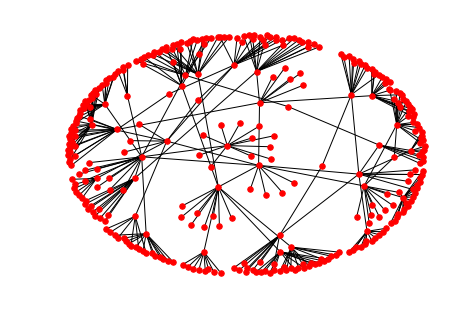

In [191]:
net.draw_spring(g1,node_size=30)

In [192]:
g.neighbors('lindapugliese')

[u'robdowsley',
 u'martynthompsonstudio',
 u'covergirl',
 u'andrewbmyers',
 u'chroniclebooks',
 u'mattarmendarizphoto-blog',
 u'thegeometryofpasta',
 u'pigeonpie4two',
 u'chewblr',
 u'artspotting']

## Reference
  
* https://github.com/tumblr/pytumblr  
* https://stackoverflow.com/a/3277515/8066374  
* https://networkx.github.io/documentation/networkx-1.10/  
* Tsvetovat, Kouznetsov (2011). Social Network Analysis for Startups  
